In [1]:
# Essential Imports
import numpy as np
import torch
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

In [2]:
# Local imports
from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files

from scnn import SNN, SpikingDenseLayer, SpikingConv2DLayer, SpikingConv3DLayer
from scnn.heaviside import SurrogateHeaviside

from scnn.optim import RAdam

In [3]:
# Tools Import
from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from tools.notify import notify
te = TimeExpector()

def print_progress(msg, value, width=80, a='=', b='>', c='.'):
    print('\r%s [%s%s%s] %d%%' % (msg, a*int(value*width), b, c*int((1.-value)*width), value*100), end='')

In [4]:
batch_size = 16
nb_epochs = 2

In [5]:
# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")
    
dtype = torch.float

using cpu...


In [6]:
# FIXME
my_laptop = True
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    print('remove this')
    trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=20
    )

# calculate train dataset size
dataset_size = 0.
for x_batch, y_batch in load_data('train'):
    dataset_size += 1.
    if dataset_size % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size, end='')
print('\rpre-processing dataset: %d' % dataset_size)

remove this
pre-processing dataset: 137


In [7]:
%matplotlib inline

from matplotlib.gridspec import GridSpec

def plot_spikes_in_time(layer, batch_id=0):
    if layer.IS_CONV:
        _plot_spikes_conv(layer, batch_id)
    else:
        _plot_spikes_dense(layer, batch_id)


def _plot_spikes_dense(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    for i in range(mem_rec_hist.shape[1]):
        plt.plot(mem_rec_hist[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    
    plt.show()
    plt.plot(spk_rec_hist,'b.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(spk_rec_hist)
    plt.xlabel('Neuron')
    plt.ylabel('Spike Time')
    plt.axis([-1, spk_rec_hist.shape[1], -1, spk_rec_hist.shape[0]])
    plt.show()
    

def _plot_spikes_conv(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    time_step = mem_rec_hist.shape[1]
    channels = mem_rec_hist.shape[0]
    rest_shape = mem_rec_hist.shape[2:]
    
    tmp_spk = np.zeros((time_step, channels, *rest_shape))
    tmp_mem = np.zeros((time_step, channels, *rest_shape))
    for i in range(time_step):
        tmp_spk[i, :, :, :] = spk_rec_hist[:, i, :, :]
        tmp_mem[i, :, :, :] = mem_rec_hist[:, i, :, :]
    spk_rec_hist = tmp_spk
    mem_rec_hist = tmp_mem
    
    flat_spk = np.reshape(spk_rec_hist, (time_step, channels*np.prod(mem_rec_hist.shape[2:])))
    flat_mem = np.reshape(mem_rec_hist, (time_step, channels*np.prod(mem_rec_hist.shape[2:])))
    
    # Plot Flats
    max_flats = 25
    if flat_mem.shape[1] > max_flats:
        inx = np.random.randint(flat_mem.shape[1], size=max_flats)
        flat_spk = flat_spk[:, inx]
        flat_mem = flat_mem[:, inx]
    
    for i in range(flat_mem.shape[1]):
        plt.plot(flat_mem[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    plt.show()
    
    plt.plot(flat_spk,'.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(flat_spk, cmap=plt.cm.gray_r, origin="lower", aspect='auto')
    plt.xlabel('Neuron')
    plt.ylabel ('Spike Time')
    plt.axis([-1, flat_spk.shape[1], -1, flat_spk.shape[0]])
    plt.show()
    
    # Visual Plots
    max_visual = 5
    
#     debug_print(spk_rec_hist, 'spk', pytorch=False)
#     debug_print(mem_rec_hist, 'mem', pytorch=False)

    time_idx = list(range(0, time_step, int(time_step/max_visual)))
    neur_idx = np.random.randint(mem_rec_hist.shape[1], size=max_visual)

    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

#     counter = 0
#     for n in neur_idx:
#         for t in time_idx:
#             if counter == 0:
#                 a0 = ax = plt.subplot(gs[counter])
#             else:
#                 ax = plt.subplot(gs[counter], sharey=a0)
#             ax.imshow(spk_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
#             plt.title('t(%d) - n(%d)' % (t, n))
#             counter += 1
#     plt.show()
    
    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

    counter = 0
    for n in neur_idx:
        for t in time_idx:
            if counter == 0:
                a0 = ax = plt.subplot(gs[counter])
            else:
                ax = plt.subplot(gs[counter], sharey=a0)
            ax.imshow(mem_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
            plt.title('t(%d) - n(%d)' % (t, n))
            counter += 1

In [8]:
def debug_print(val, name, show_data=False, pytorch=True):
    print('%s' % name, val.shape)
    if show_data:
        print(val)
    if pytorch:
        print('min=%.2f | mean=%.2f | max=%.2f' % (torch.min(val), torch.mean(val), torch.max(val)))
    else:
        print('min=%.2f | mean=%.2f | max=%.2f' % (np.min(val), np.mean(val), np.max(val)))
    print('\n---------------------------------------------------------------\n')

In [9]:
# import torch

# from scnn.conv1d import SpikingConv1DLayer
# from scnn.conv2d import SpikingConv2DLayer
# from scnn.conv3d import SpikingConv3DLayer
# from scnn.pool2d import SpikingPool2DLayer
# from scnn.dense import SpikingDenseLayer
# from scnn.readout import ReadoutLayer
# from scnn.heaviside import SurrogateHeaviside


# class SNN(torch.nn.Module):
#     def __init__(self, spike_fn=None):
#         super(SNN, self).__init__()
#         self.layers = []
#         self.default_spike_fn = spike_fn if spike_fn is not None else SurrogateHeaviside.apply
#         self.last_layer_shape = None
#         self.last_layer_is_conv = None

#     def add_conv1d(self, **kwargs):
#         self.add_layer(SpikingConv1DLayer, **kwargs)

#     def add_conv2d(self, **kwargs):
#         self.add_layer(SpikingConv2DLayer, **kwargs)

#     def add_conv3d(self, **kwargs):
#         self.add_layer(SpikingConv3DLayer, **kwargs)

#     def add_pool2d(self, **kwargs):
#         self.add_layer(SpikingPool2DLayer, **kwargs)

#     def add_dense(self, **kwargs):
#         self.add_layer(SpikingDenseLayer, **kwargs)

#     def add_readout(self, **kwargs):
#         self.add_layer(ReadoutLayer, **kwargs)

#     def add_layer(self, layer, **kwargs):
#         if layer.IS_SPIKING and self.default_spike_fn is not None and 'spike_fn' not in kwargs:
#             kwargs['spike_fn'] = self.default_spike_fn

#         if not layer.IS_CONV and self.last_layer_is_conv:
#             self.layers[-1].flatten_output = True

#         # calculating this layer inputs based on last layer
#         if self.last_layer_shape is not None:
#             llsh = self.last_layer_shape
#             if layer.IS_CONV and 'input_channels' not in kwargs and 'input_shape' not in kwargs:
#                 if self.last_layer_is_conv:
#                     kwargs['input_channels'] = llsh['channels']
#                     kwargs['input_shape'] = llsh['shape']
#                 else:
#                     raise NotImplementedError()  # FIXME : handle if last layer was not conv
#             elif not layer.IS_CONV and 'input_shape' not in kwargs:
#                 if self.last_layer_is_conv:
#                     input_shape = 1
#                     for i in range(len(llsh['shape'])):
#                         input_shape *= llsh['shape'][i]
#                     input_shape *= llsh['channels']
#                     kwargs['input_shape'] = input_shape
#                 else:
#                     kwargs['input_shape'] = llsh['shape']

#         new_layer = layer(**kwargs)
#         if new_layer.IS_CONV:
#             self.last_layer_shape = {'channels': new_layer.output_channels, 'shape': new_layer.output_shape}
#         else:
#             self.last_layer_shape = {'shape': new_layer.output_shape}

#         self.layers.append(new_layer)
#         self.last_layer_is_conv = layer.IS_CONV

#     def compile(self):
#         self.layers = torch.nn.ModuleList(self.layers)

#     def forward(self, x):
#         shp = x.shape
#         if self.layers[0].IS_CONV:
#             x = x.view(shp[0], 1, shp[1], shp[2], shp[3])
#         else:
#             x = x.view(shp[0], shp[1], shp[2] * shp[3])
                    
#         for l in self.layers:
#             x = l(x)
#         return x

#     def clamp(self):
#         for l in self.layers:
#             l.clamp()

#     def reset_parameters(self):
#         for l in self.layers:
#             l.reset_parameters()

#     def fit(self, train_dl, valid_dl, epochs=5, loss_func=None, optimizer=None):
#         # fix params before proceeding
#         if loss_func is None:
#             loss_func = torch.nn.NLLLoss()
        
#         # train code
#         for epoch in range(epochs):
#             te.tick(epochs-epoch)
            
#             # train
#             dataset_counter = 0
#             self.train()
#             losses = []; nums = []
#             for x_batch, y_batch in train_dl:
#                 dataset_counter += 1
#                 print_progress('Epoch: %d' % epoch, dataset_counter/dataset_size)
                
#                 x_batch = torch.from_numpy(x_batch).to(device, dtype) # FIXME
#                 y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device) # FIXME
#                 l, n = self.batch_step(loss_func, x_batch, y_batch, optimizer)
#                 losses.append(l)
#                 nums.append(n)
#             train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
                
                
#             # evaluate
#             self.eval()
#             with torch.no_grad():
#                 losses = []; nums = []
#                 for x_batch, y_batch in valid_dl:
#                     x_batch = torch.from_numpy(x_batch).to(device, dtype) # FIXME
#                     y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device) # FIXME
#                     l, n = self.batch_step(loss_func, x_batch, y_batch)
#                     losses.append(l)
#                     nums.append(n)
#             val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

#             # finishing up
#             print("  |  loss=%.3f  val_loss=%.3f"%(train_loss, val_loss))
            
#             train_accuracy = self.compute_classification_accuracy(train_dl)
#             valid_accuracy = self.compute_classification_accuracy(valid_dl)
#             print('(train_accuracy=%.2f%%  |  valid_accuracy=%.2f%%)' % (train_accuracy*100., valid_accuracy*100.))
#             te.tock()
            
#     def batch_step(self, loss_func, xb, yb, opt=None):
#         log_softmax_fn = torch.nn.LogSoftmax(dim=1) # TODO: investigate this
        
#         y_pred = self(xb)
#         log_y_pred = log_softmax_fn(y_pred)
#         loss = loss_func(log_y_pred, yb)

#         if opt is not None:
#             loss.backward()
#             torch.nn.utils.clip_grad_value_(self.parameters(), 5) # TODO: investigate this
#             opt.step()
#             self.clamp() # TODO: investigate this
#             opt.zero_grad()

#         return loss.item(), len(xb)

#     def compute_classification_accuracy(self, data_dl):
#         accs = []
#         with torch.no_grad():
#             for x_batch, y_batch in data_dl:
#                 x_batch = torch.from_numpy(x_batch).to(device, dtype)
#                 y_batch = torch.from_numpy(y_batch.astype(np.long))
#                 output = self(x_batch)
#                 _,am = torch.max(output,1) # argmax over output units
#                 tmp = np.mean((y_batch == am).detach().numpy()) # compare to labels
#                 accs.append(tmp)
#         return np.mean(accs)

In [10]:
network = SNN().to(device, dtype)


tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)


# network.add_layer(NewSpiker,
#     input_shape=4096,
#     output_shape=128,
                  
#     w_init_mean=0.0,
#     w_init_std=weight_scale
# )

network.add_conv3d(input_shape=(64,64),
                   output_shape=(64,64),
                   input_channels=1,
                   output_channels=32,
                   kernel_size=(1,3,3),
                   dilation=(1,1,1),
                   lateral_connections=False,
)

# network.add_layer(SpikingPool2DLayer, kernel_size=(2,2), output_channels=32)
network.add_pool2d(kernel_size=(2,2), output_channels=32)


# network.add_dense(
#     input_shape=4096,
#     output_shape=256,
#    w_init_mean=0.006,
# #     w_init_std=.96,
#     lateral_connections=True
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=256
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=128,
#     w_init_mean=.19
# )

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()

remove this
x shape= torch.Size([16, 20, 64, 64])
Layer 0: average number of spikes=0.0626


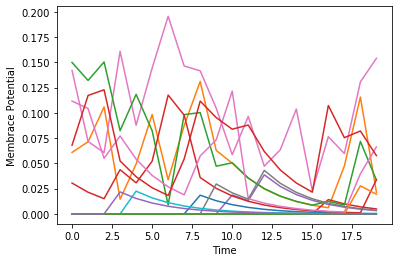

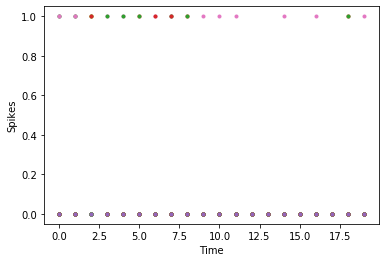

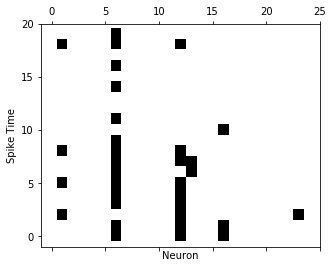

Layer 1: average number of spikes=0.1061


<Figure size 2160x1440 with 0 Axes>

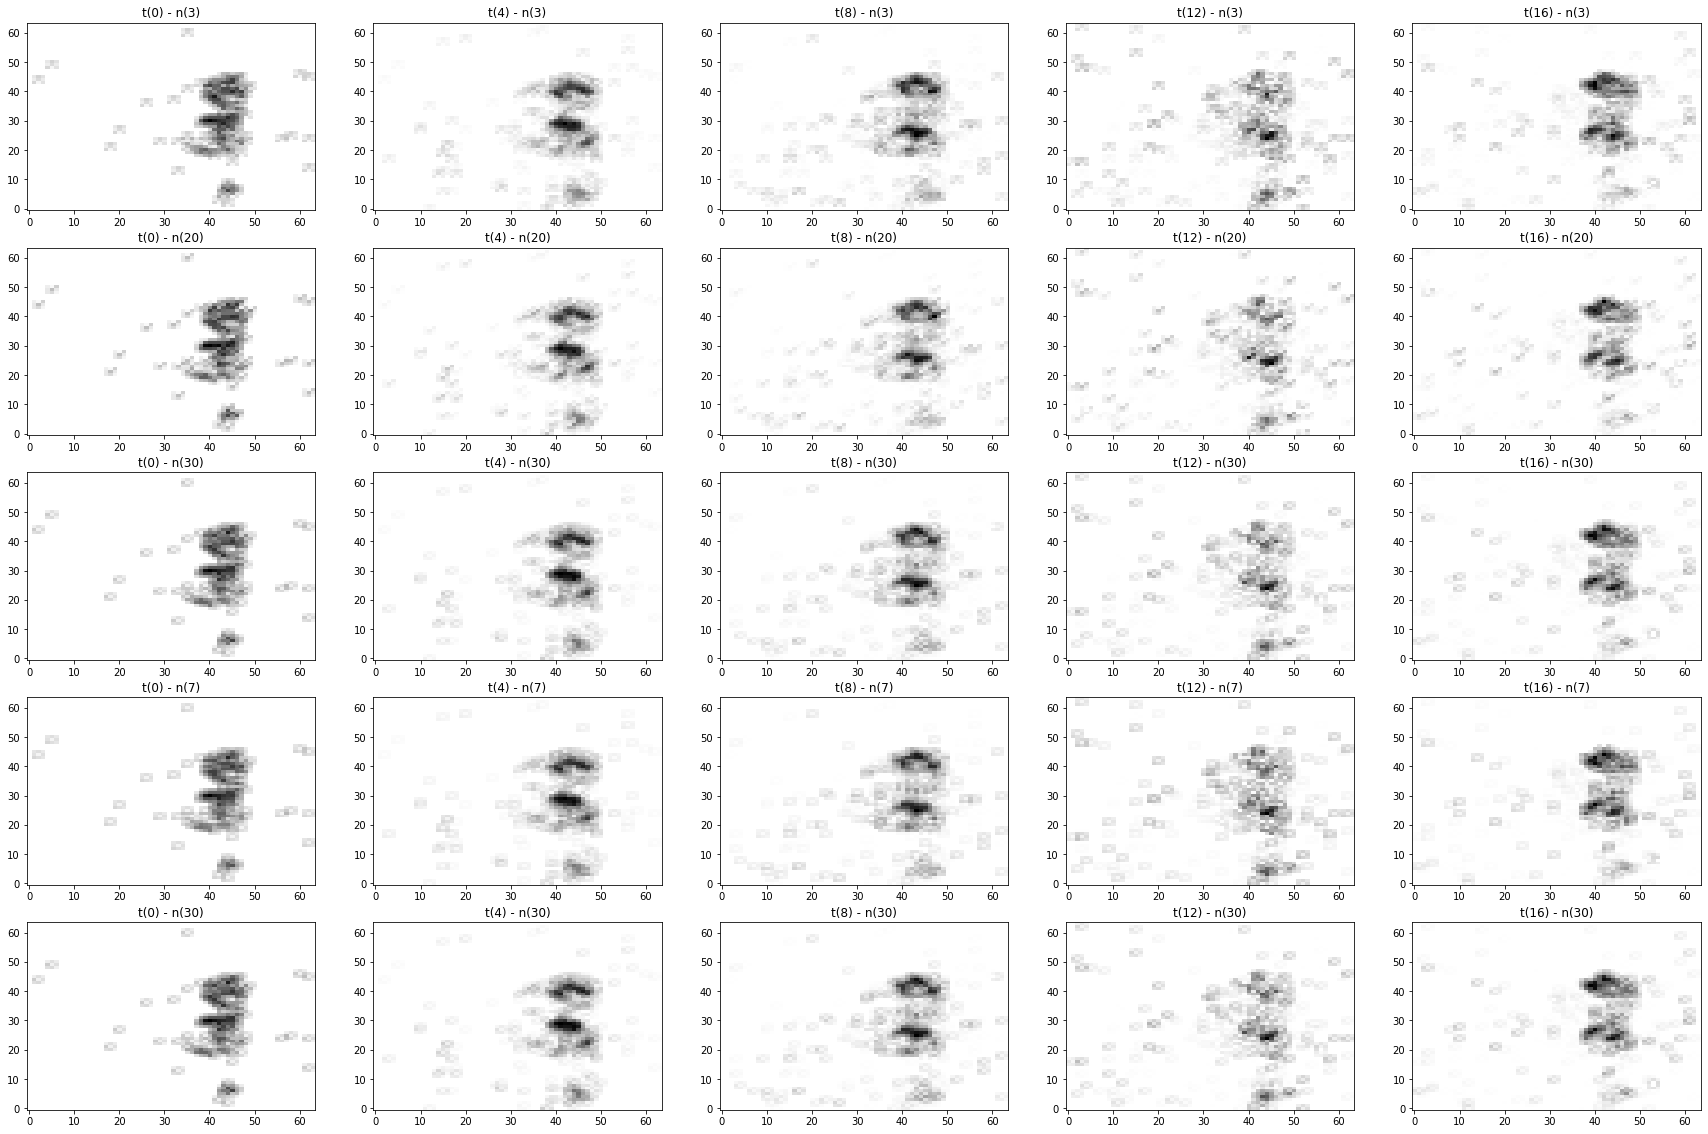

In [11]:
for X_batch, _ in load_data('train'):
    break

X_batch = torch.from_numpy(X_batch).to(device, dtype)
print('x shape=', X_batch.shape)

network(X_batch)

for i,l in enumerate(network.layers):
    if 'spk_rec_hist' in l.__dict__:
        print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        if l.HAS_PARAM:
            plot_spikes_in_time(l)

In [12]:
# nb_plt = min(batch_size, 9)

# batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# # Plotting spike trains or membrane potential
# for i,l in enumerate(network.layers):
#     if not l.HAS_PARAM:
#         continue
    
#     if isinstance(l, SpikingDenseLayer):
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec, idx=batch_idx)
#     elif isinstance(l, SpikingConv2DLayer):
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
#     elif isinstance(l, SpikingConv3DLayer):
#         spk_rec = l.spk_rec_hist
#         plot_spk_rec(spk_rec.sum(1).sum(1), idx=batch_idx)
#     else:
#         mem_rec = l.mem_rec_hist
#         plot_mem_rec(mem_rec, batch_idx)

In [13]:
# def train(model, params, optimizer, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
#     log_softmax_fn = torch.nn.LogSoftmax(dim=1)
#     loss_fn = torch.nn.NLLLoss()
    
#     if warmup_epochs > 0:
#         for g in optimizer.param_groups:
#             g['lr'] /= 1000*warmup_epochs
#         warmup_itr = 1
    
#     hist = {'loss':[], 'valid_accuracy':[]}
#     for e in range(nb_epochs):
#         te.tick(nb_epochs-e)
#         print('\n')
#         local_loss = []
# #         reg_loss = [[] for _ in range(len(model.layers)-1)]
        
#         #with tqdm_notebook(total=len(train_dataloader)) as pb:
#         e_2 = 0
#         for x_batch, y_batch in load_data('train'):
#             e_2 += 1
#             print_progress('Epoch: %d' % e, e_2/dataset_size)
#             #print('\r%d -- %d' % (e, e_2), end='')
#             shp = x_batch.shape
#             if model.layers[0].IS_CONV:
#                 x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
#             else:
#                 x_batch = np.reshape(x_batch, [shp[0], shp[1], shp[2] * shp[3]])
        
        
#             x_batch = torch.from_numpy(x_batch).to(device, dtype)
#             y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)

# #             print('a')
#             output, loss_seq = model(x_batch)
#             log_p_y = log_softmax_fn(output)
#             loss_val = loss_fn(log_p_y, y_batch)
#             local_loss.append(loss_val.item())

# #             print('b')
# #             for i,loss in enumerate(loss_seq[:-1]):
# #                 print('  -', i)
# #                 reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
# #                 loss_val += reg_loss_val
# #                 reg_loss[i].append(reg_loss_val.item())


#             optimizer.zero_grad()
#             loss_val.backward()
#             torch.nn.utils.clip_grad_value_(model.parameters(), 5)
#             optimizer.step()
#             model.clamp()
            
#             if e < warmup_epochs:
#                 for g in optimizer.param_groups:
#                     g['lr'] *= (warmup_itr+1)/(warmup_itr)
#                 warmup_itr += 1
                
#                 #pb.update(1)
                
#         if scheduler is not None and e >= warmup_epochs:
#             scheduler.step()
        
#         mean_loss = np.mean(local_loss)
#         hist['loss'].append(mean_loss)
#         print("  |  loss=%.5f"%(mean_loss))
        
# #         for i,loss in enumerate(reg_loss):
# #             mean_reg_loss = np.mean(loss)
# #             print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
#         for i,l in enumerate(network.layers[:-1]):
#             print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
#         valid_accuracy = compute_classification_accuracy(model, 'test')
#         hist['valid_accuracy'].append(valid_accuracy)
#         print("Validation accuracy=%.3f"%(valid_accuracy))
#         te.tock()
        
#     return hist
        
# def compute_classification_accuracy(model, trail):
#     accs = []
    
#     with torch.no_grad():
#         #with tqdm_notebook(total=len(dataloader)) as pb:
#         for x_batch, y_batch in load_data(trail):
#             shp = x_batch.shape
#             if model.layers[0].IS_CONV:
#                 x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
#             else:
#                 x_batch = np.reshape(x_batch, [shp[0], shp[1], shp[2] * shp[3]])
#             x_batch = torch.from_numpy(x_batch).to(device, dtype)
#             y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)
#             output, _ = model(x_batch)
#             _,am=torch.max(output,1) # argmax over output units
#             tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
#             accs.append(tmp)
#                 #pb.update(1)
#     return np.mean(accs)

In [ ]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1

# params = []
# for i,l in enumerate(network.layers):
#     if l.HAS_PARAM:
#         params.append({'params':l.w, 'lr':lr, "weight_decay":weight_decay})
# for i,l in enumerate(network.layers[:-1]):
#     if l.HAS_PARAM and l.recurrent:
#         params.append({'params':l.v, 'lr':lr, "weight_decay":weight_decay})
# for i,l in enumerate(network.layers):
#     if l.HAS_PARAM:
#         params.append({'params':l.b, 'lr':lr})
    
# if network.layers[-1].time_reduction == "mean":
#     params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(network.layers[:-1])]
# elif network.layers[-1].time_reduction == "max":
#     params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(network.layers)]
# else:
#     raise ValueError("Readout time recution should be 'max' or 'mean'")
    
# optimizer = RAdam(params)
 
# gamma = 0.85
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

# hist = train(network, None, optimizer, reg_loss_coef, nb_epochs=nb_epochs,
#                   scheduler=scheduler, warmup_epochs=1)

train_dl = load_data('train')
valid_dl = load_data('test')

# opt = RAdam(network.get_trainable_parameters())
opt = torch.optim.SGD(network.get_trainable_parameters(), lr=lr, momentum=0.9)
network.fit(load_data, optimizer=opt, dataset_size=dataset_size)

train_accuracy = network.compute_classification_accuracy(train_dl)
print("Train accuracy=%.3f"%(train_accuracy))
test_accuracy = network.compute_classification_accuracy(valid_dl)
print("Test accuracy=%.3f"%(test_accuracy))

remove this
remove this
remove this
Epoch: 0 [================================================================================>] 100%remove this
  |  loss=2.470  val_loss=2.455
remove this
remove this
(train_accuracy=20.62%  |  valid_accuracy=20.62%)
remove this
Epoch: 1 [======================>.........................................................] 28%

In [ ]:
for X_batch, _ in load_data('train'):
    break
    
shp = X_batch.shape

if network.layers[0].IS_CONV:
    X_batch = np.reshape(X_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
else:
    X_batch = np.reshape(X_batch, [shp[0], shp[1], shp[2] * shp[3]])

X_batch = torch.from_numpy(X_batch).to(device, dtype)
print('x shape=', X_batch.shape)

network(X_batch)

for i,l in enumerate(network.layers):
    if 'spk_rec_hist' in l.__dict__:
        print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
    if l.HAS_PARAM:
        plot_spikes_in_time(l)

In [ ]:
network(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(network.layers):
    if not l.HAS_PARAM:
        continue
        
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, 0)